In [1]:
import copy
import math
import struct
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import csv
from scipy.interpolate import interp1d
from scipy.stats import pearsonr, mode,kurtosis,skew
from scipy.signal import savgol_filter
import xgboost as xgb
import sklearn
import copy
import warnings
import multiprocessing

from scipy.stats import kurtosis
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error,plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d
from joblib import Parallel, delayed


if '/home/grads/s/' in os.getcwd():
    addressPrefix='/home/grads/s/sorush.omidvar/CGMDataset/Hoover/'
else:
    addressPrefix='C:/Users/sorush.omidvar/Google Drive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/'
    if not os.path.exists(addressPrefix):
        addressPrefix='C:/GDrive/Documents/Educational/TAMU/Research/CGM Dataset/Hoover/'

pd.options.mode.chained_assignment = None  # default='warn'
plt.style.use({'figure.facecolor':'white'})
coreNumber=np.min([multiprocessing.cpu_count(),12])
pd.set_option('display.max_rows', 500)

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
def pdFormatter(df):
    for counter in range(len(df)):
        tempStr=df.iloc[counter,1]
        tempVal=int(tempStr[0:2])*3600+int(tempStr[3:5])*60+int(tempStr[6:8])
        tempVal*=1000
        df.iloc[counter,1]=tempVal

        tempStr=df.iloc[counter,2]
        tempVal=int(tempStr[0:2])*3600+int(tempStr[3:5])*60+int(tempStr[6:8])
        tempVal*=1000
        df.iloc[counter,2]=tempVal
        if df.iloc[counter,1]>df.iloc[counter,2]:
            df.iloc[counter,2]+=24*3600*1000
    df.sort_values(by=['Name','Start','End'],inplace=True)

    return df

def labelReader(addressPrefix):
    labelFiles=[]
    for root, dirs, files in os.walk(addressPrefix, topdown=False):
       for name in files:
           if '.txt' in name:
               labelFiles.append([os.path.join(root,name),name])
    mealTime=[]
    sensorTiming=[]
    for element in labelFiles:
        nameTemp=element[1]
        nameTemp=nameTemp[:nameTemp.find('-events')]
        with open(element[0], 'r+') as txtfile:
            fileData = txtfile.read()
            fileData=fileData.splitlines()
            while '' in fileData:
                fileData.remove('')
            tempStart=fileData[0]
            tempStart=tempStart.split()
            tempStart=tempStart[2]

            tempEnd=fileData[-1]
            tempEnd=tempEnd.split()
            tempEnd=tempEnd[2]

            sensorTiming.append([nameTemp,tempStart,tempEnd])
            for counter in range(1,len(fileData)-1):
                tempStr=fileData[counter]
                tempStr=tempStr.split()
                mealTime.append([nameTemp,tempStr[1],tempStr[2]])

    dfMeal=pd.DataFrame(mealTime,columns=['Name','Start','End'])
    dfMeal=pdFormatter(dfMeal)

    dfTime=pd.DataFrame(sensorTiming,columns=['Name','Start','End'])
    dfTime=pdFormatter(dfTime)

    return dfMeal,dfTime

def shimmerReader(element):
    nameTemp=element[1]
    dataList=[]
    tempList=[]
    with open(element[0], mode='rb') as txtfile:
        fileData = txtfile.read()
        for i in range(int(len(fileData)/4)):
            if i%6==0 and i!=0:
                tempList.append(nameTemp)
                dataList.append(tempList)
                tempList=[]
            tempVal=fileData[i*4:(i+1)*4]
            tempVal=struct.unpack('f',tempVal)
            tempVal=tempVal[0]
            tempList.append(tempVal)
    txtfile.close()

    dfSensor=pd.DataFrame(dataList,columns=[ 'X','Y','Z','Yaw','Pitch','Roll','Name'])
    dfSensor=dfSensor[['Name','X','Y','Z','Yaw','Pitch','Roll']]
    del dataList
    return dfSensor

def timeFinder(dfSensor,dfTime):
    dfSensor.insert(1,'Time',float('nan'))
    name=dfSensor['Name'].tolist()
    name=name[0]
    dfTemp=dfTime[dfTime['Name']==name]

    if len(dfTemp)>1:
        print('More than one event file for:',name)
        return
    elif len(dfTemp)==0:
        print('No event file for:',name)
        return
    startTemp=dfTemp['Start'].tolist()
    endTemp=dfTemp['End'].tolist()
    tempTimeStamp=np.linspace(startTemp,endTemp,num=len(dfSensor))
    dfSensor['Time']=tempTimeStamp
    return dfSensor

def featureExtractor(df):
    windowLength=60*1000
    featureData=[]
    name=df['Name'].tolist()
    name=name[0]
    dfName=df[df['Name']==name]
    startTime=dfName['Time'].min()
    endTime=startTime+windowLength

    while startTime<24*3600*1000:
        dfTemp=dfName[dfName['Time']>=startTime]
        dfTemp=dfTemp[dfTemp['Time']<endTime]
        if len(dfTemp)>5*15:
            features=[]
            f1=abs(dfTemp['Yaw'].values)+abs(dfTemp['Roll'].values)+abs(dfTemp['Pitch'].values)
            f2=abs(dfTemp['X'].values)+abs(dfTemp['Y'].values)+abs(dfTemp['Z'].values)
            f2+=0.0001
            f1=f1/f2
            f1=np.mean(f1)
            f2=np.mean(f2)
            if np.isnan(f1):
                print('Nan F1 Value')
                continue
            features.append(f1)
            features.append(f2)
            for axe in dfTemp.columns:
                if axe=='Time' or axe=='Name':
                    continue

                tempVal=np.mean(abs(dfTemp[axe].values))
                features.append(tempVal)

                tempVal=np.std(abs(dfTemp[axe].values))
                features.append(tempVal)

                tempVal=np.ptp(dfTemp[axe].values)
                features.append(tempVal)

                tempVal=np.mean(dfTemp[axe].values)
                features.append(tempVal)

                tempVal=np.std(dfTemp[axe].values)
                features.append(tempVal)

                tempVal=skew(dfTemp[axe].values)
                features.append(tempVal)

                tempVal=kurtosis(dfTemp[axe].values)
                features.append(tempVal)

            features.extend([name,startTime,endTime])
            featureData.append(features)
        startTime+=windowLength
        endTime+=windowLength
    return featureData

def labelExtractor(dfMeal,features):
    dataTotal=[]

    for feature in features:
        dataTemp=[]
        windowName=feature[-3]
        windowStart=feature[-2]
        windowEnd=feature[-1]
        dfTemp=dfMeal[dfMeal['Name']==windowName]
        if len(dfTemp)==0:
            print('skipped',windowName)
            break
        eatingFlag=False
        for counter in range(0,len(dfTemp)):
            if dfTemp.iloc[counter,1]<windowEnd and dfTemp.iloc[counter,2]>windowStart:
                eatingFlag=True
                break
        dataTemp.extend(feature[:len(feature)-3])
        dataTemp.extend([windowName,eatingFlag])
        dataTotal.append(dataTemp)

    return dataTotal

def callerFunc(element,dfMeal,dfTime):

    dfSensor=shimmerReader(element)
    dfSensor=timeFinder(dfSensor,dfTime)
    featureData=featureExtractor(dfSensor)
    allData=labelExtractor(dfMeal,featureData)
    print(dfSensor.columns)

    return allData

def main(addressPrefix):
    shimmerFiles=[]
    dfMeal,dfTime=labelReader(os.path.join(addressPrefix,'EVENTfiles'))

    for root, dirs, files in os.walk(os.path.join(addressPrefix,'SHMfiles'), topdown=False):
       for name in files:
           if '.shm' in name:
               shimmerFiles.append([os.path.join(root,name),name[:-4]])
    print(coreNumber)
    # shimmerFiles=shimmerFiles[0:4]
    allData=Parallel(n_jobs=coreNumber)(delayed(callerFunc)(i, dfMeal,dfTime) for i in tqdm(shimmerFiles))
    headers=['f1','f2']
    columns=['X', 'Y', 'Z', 'Yaw', 'Pitch', 'Roll']
    stats=['mean abs','std abd','range','mean','std','skew','kurtosis']
    for column in columns:
        for stat in stats:
            headers.append(column+'-'+stat)
    # callerFunc(shimmerFiles[0],dfMeal,dfTime)

    headers.extend(['Name','EatingFlag'])
    allData = [ item for elem in allData for item in elem]
    dfAllData=pd.DataFrame(allData,columns=headers)
    dfAllData.to_csv(os.path.join(addressPrefix,'AllDataParallel.csv'),index=False)
    return dfAllData

dfAllData=main(addressPrefix)

12


100%|██████████| 354/354 [12:04<00:00,  2.05s/it]


[0.01802181 0.01770566 0.08257793 0.03350129 0.01249163 0.04085927
 0.00943028 0.01247172 0.01123224 0.020838   0.050857   0.00831277
 0.01464733 0.00710227 0.00821901 0.02025507 0.00536154 0.02570903
 0.01208438 0.02572895 0.00662165 0.02347297 0.01055361 0.01065995
 0.0066825  0.01306615 0.00666498 0.00974767 0.02821975 0.10593902
 0.09127348 0.00587354 0.01348158 0.00814368 0.01967038 0.01473048
 0.04225162 0.01354357 0.00664448 0.00895173 0.01764375 0.01107245
 0.08768377]
Testing on test dataset:
[[0.74212937 0.19717394]
 [0.02139771 0.03929898]]
Accuracy 78.0 Recall 65.0 Precision 17.0


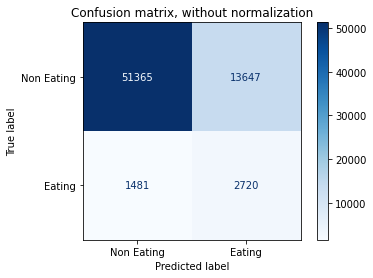

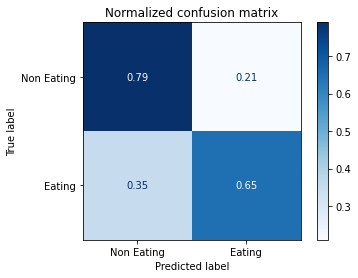

In [3]:
def modelVisualizer(testData,testLabels,modelBest):
    slidingWindowPrediction = modelBest.predict(testData)
    confMatrix=sklearn.metrics.confusion_matrix(testLabels,slidingWindowPrediction,normalize='all')
    accuracy=sklearn.metrics.accuracy_score(testLabels,slidingWindowPrediction)
    recall=sklearn.metrics.recall_score(testLabels,slidingWindowPrediction)
    precision=sklearn.metrics.precision_score(testLabels,slidingWindowPrediction)

    print('Testing on test dataset:')
    print(confMatrix)
    print('Accuracy',np.round(100*accuracy,0),'Recall',np.round(100*recall,0),'Precision',np.round(100*precision,0))

    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]

    for title, normalize in titles_options:
        disp = plot_confusion_matrix(modelBest, testData, testLabels,
                                     display_labels=['Non Eating','Eating'],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)
    plt.show()


def xgClassifier(dataList, labelList,randomSeed):
    trainData, testData, trainLabels, testLabels = train_test_split(dataList, labelList, test_size=0.25,random_state=randomSeed)
    trainData, valData, trainLabels, valLabels = train_test_split(trainData, trainLabels, test_size=0.33,random_state=randomSeed)
    oversample = SMOTE()
    trainData,trainLabels = oversample.fit_resample(trainData,trainLabels)
    f1Best=0
    for maxDepth in np.arange(2,7):
        for estimator in np.arange(20,30,200):
            clf = xgb.XGBClassifier(n_estimators=estimator,max_depth=maxDepth,objective = "binary:logistic",
                                    eval_metric = "logloss",use_label_encoder =False,scale_pos_weight=1,random_state=randomSeed,n_jobs=coreNumber)
            clf.fit(trainData, trainLabels)
            slidingWindowPrediction = clf.predict(valData)
            accuracy=sklearn.metrics.accuracy_score(valLabels,slidingWindowPrediction)
            recall=sklearn.metrics.recall_score(valLabels,slidingWindowPrediction)
            precision=sklearn.metrics.precision_score(valLabels,slidingWindowPrediction)
            f1=sklearn.metrics.f1_score(valLabels,slidingWindowPrediction,average='weighted')

            if f1>f1Best:
                f1Best=f1
                maxDepthBest=maxDepth
                estimatorBest=estimator
                accuracyBest=accuracy
                modelBest=clf
                recallBest=recall
                precisionBest=precision
    print(modelBest.feature_importances_)
    modelVisualizer(testData,testLabels,modelBest)

def randomForestClassifier(dataList,labelList,randomSeed):
    trainData, testData, trainLabels, testLabels = train_test_split(dataList, labelList, test_size=0.25,random_state=randomSeed)
    trainData, valData, trainLabels, valLabels = train_test_split(trainData, trainLabels, test_size=0.33,random_state=randomSeed)
    oversample = SMOTE()
    trainData,trainLabels = oversample.fit_resample(trainData,trainLabels)
    f1Best=0
    for treeNum in np.arange(10,100,10):
        for maxDepth in np.arange(3,10):
            clf=RandomForestClassifier(n_estimators=treeNum,criterion='entropy',random_state=0,max_depth=maxDepth,n_jobs=coreNumber)
            clf.fit(trainData,trainLabels)
            slidingWindowPrediction=clf.predict(valData)
            accuracy=sklearn.metrics.accuracy_score(valLabels,slidingWindowPrediction)
            recall=sklearn.metrics.recall_score(valLabels,slidingWindowPrediction)
            precision=sklearn.metrics.precision_score(valLabels,slidingWindowPrediction)
            f1=sklearn.metrics.f1_score(valLabels,slidingWindowPrediction,average='weighted')

            if f1>f1Best:
                f1Best=f1
                maxDepthBest=maxDepth
                treeNumBest=treeNum
                accuracyBest=accuracy
                modelBest=clf
                recallBest=recall
                precisionBest=precision

    modelVisualizer(testData,testLabels,modelBest)

data=pd.read_csv(os.path.join(addressPrefix,'AllDataParallel.csv'))
allLabel=data['EatingFlag'].values
allLabel=np.asarray(allLabel,dtype=int)

data.drop(columns=['Name','EatingFlag'],inplace=True)
allData=data.values
allData=np.asarray(allData,dtype=float)
allData=allData[:,1:]
for axis in range(allData.shape[1]):
    allData[:,axis]-=np.mean(allData[:,axis])
    allData[:,axis]/=np.std(allData[:,axis])

xgClassifier(allData, allLabel,randomSeed=78)